## Comparing the PIR and HARK solution

- this notebook compare my code and HARK solutions 
- author: Tao Wang
- date: Feb 2022
- this is a companion notebook to the paper "Perceived income risks"

In [1]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from copy import copy

In [2]:
## plot configuration 

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

In [3]:
from SolveLifeCycleMABelief import LifeCycle, solve_model_iter
from PrepareParameters import life_cycle_paras_y 

### parameters 

In [4]:
inf_paras = copy(life_cycle_paras_y)
inf_paras['G'] =  np.ones_like(inf_paras['G'])
inf_paras['unemp_insurance'] = 0.0
inf_paras['P'] = np.array([[0.9,0.1],[0.2,0.8]])

grid_max = 10.0
grid_size = 100

In [5]:
inf_mkv = LifeCycle(U = inf_paras['U'], ## transitory ue risk
                    unemp_insurance = inf_paras['unemp_insurance'],
                    pension = inf_paras['pension'], ## pension
                    sigma_psi = inf_paras['σ_ψ'], # permanent 
                    sigma_eps = inf_paras['σ_θ'], # transitory 
                    P = inf_paras['P'],   ## transitory probability of markov state z
                    z_val = inf_paras['z_val'], ## markov state from low to high  
                    x = 0.0,           ## MA(1) coefficient of non-permanent inocme shocks
                    ue_markov = True,   
                    adjust_prob = 1.0,
                    sigma_p_init = inf_paras['σ_ψ_init'],
                    init_b = inf_paras['init_b'],
                    ## subjective risk prifile 
                    sigma_psi_2mkv = inf_paras['σ_ψ_2mkv'],  ## permanent risks in 2 markov states
                    sigma_eps_2mkv = inf_paras['σ_θ_2mkv'],  ## transitory risks in 2 markov states
                    λ = inf_paras['λ'],  ## tax rate
                    λ_SS = inf_paras['λ_SS'], ## social tax rate
                    transfer = inf_paras['transfer'],  ## transfer 
                    bequest_ratio = inf_paras['bequest_ratio'],
                    LivPrb = inf_paras['LivPrb'],       ## living probability 
                    ## life cycle 
                    T = inf_paras['T'],
                    L = inf_paras['L'],
                    G = inf_paras['G'],
                    #YPath = np.cumprod(G),
                    ## other parameters 
                    ρ = inf_paras['ρ'],     ## relative risk aversion  
                    β = inf_paras['β'],    ## discount factor
                    R = inf_paras['R'],           ## interest factor 
                    W = inf_paras['W'],            ## Wage rate
                    ## subjective models 
                    theta = 0.0, ## extrapolation parameter 
                    ## no persistent state
                    b_y = 0.0,
                    ## wether to have zero borrowing constraint 
                    borrowing_cstr = True,
                    ## a grids 
                    grid_max = grid_max,
                    grid_size = grid_size,
    )

Error at iteration 50 is 0.003299488409134188.
Error at iteration 100 is 0.0002576166316001771.
Error at iteration 150 is 2.0576281612671998e-05.
Error at iteration 200 is 1.523763277000434e-06.

Converged in 209 iterations.
Time taken, in seconds: 7.326747179031372


Text(0.5, 1.0, 'Inifite horizon solution')

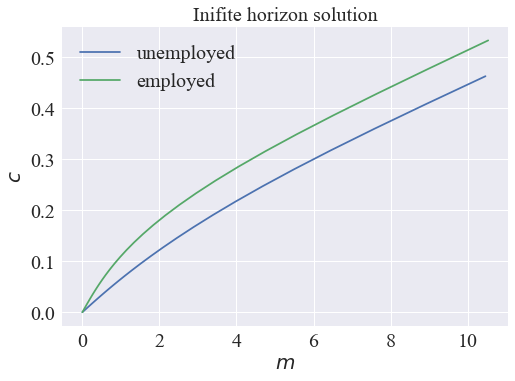

In [6]:
## initial consumption functions 


t_start = time()

a_init,σ_init = inf_mkv.terminal_solution()

a_inf_star, σ_inf_star = solve_model_iter(inf_mkv,
                                          a_init,
                                          σ_init)
t_finish = time()

print("Time taken, in seconds: "+ str(t_finish - t_start))   


## plot c func 
z_l = 0
z_h = 1

m_plt_u, c_plt_u = a_inf_star[:,0,z_l,0],σ_inf_star[:,0,z_l,0] 
m_plt_e, c_plt_e = a_inf_star[:,0,z_h,0], σ_inf_star[:,0,z_h,0]
plt.plot(m_plt_u,
         c_plt_u,
         label = 'unemployed',
        )
plt.plot(m_plt_e,
         c_plt_e,
         label = 'employed',
        )
plt.legend()
plt.xlabel(r'$m$')
plt.ylabel(r'$c$')
plt.title('Inifite horizon solution')

## Solving the same model with HARK


In [7]:
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.distribution import DiscreteDistribution
from HARK.ConsumptionSaving.ConsIndShockModel import init_lifecycle
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.utilities import plot_funcs

In [8]:
## for infinite horizon 
hark_mkv_para = copy(init_idiosyncratic_shocks)
hark_mkv_para["MrkvArray"] = [inf_paras['P']]
hark_mkv_para["UnempPrb"] = inf_paras['U']  # to make income distribution when employed
hark_mkv_para["global_markov"] = False
hark_mkv_para['CRRA'] = inf_paras['ρ']
hark_mkv_para['Rfree'] = inf_paras['R']
hark_mkv_para['LivPrb'] = [inf_paras['LivPrb']]
hark_mkv_para['PermGroFac'] = [1.0]
hark_mkv_para['PermShkStd'] = [inf_paras['σ_ψ']]
hark_mkv_para['TranShkStd'] = [inf_paras['σ_θ']]
hark_mkv_para['DiscFac'] = inf_paras['β']
hark_mkv_para['aXtraMax'] = grid_max
hark_mkv_para['aXtraCount'] = grid_size-1

In [9]:
print('HARK parameterization',str(hark_mkv_para))
print('PIR parameterization',str(inf_paras))

HARK parameterization {'cycles': 1, 'CRRA': 2.0, 'Rfree': 1.01, 'DiscFac': 0.98, 'LivPrb': [0.99375], 'PermGroFac': [1.0], 'BoroCnstArt': 0.0, 'MaxKinks': 400, 'AgentCount': 10000, 'aNrmInitMean': 0.0, 'aNrmInitStd': 1.0, 'pLvlInitMean': 0.0, 'pLvlInitStd': 0.0, 'PermGroFacAgg': 1.0, 'T_age': None, 'T_cycle': 1, 'PerfMITShk': False, 'aXtraMin': 0.001, 'aXtraMax': 10.0, 'aXtraNestFac': 3, 'aXtraCount': 99, 'aXtraExtra': [None], 'PermShkStd': [0.15], 'PermShkCount': 7, 'TranShkStd': [0.15], 'TranShkCount': 7, 'UnempPrb': 0.0, 'UnempPrbRet': 0.005, 'IncUnemp': 0.3, 'IncUnempRet': 0.0, 'tax_rate': 0.0, 'T_retire': 0, 'vFuncBool': False, 'CubicBool': False, 'neutral_measure': False, 'MrkvArray': [array([[0.9, 0.1],
       [0.2, 0.8]])], 'global_markov': False}
PIR parameterization {'ρ': 2.0, 'β': 0.98, 'P': array([[0.9, 0.1],
       [0.2, 0.8]]), 'z_val': array([0., 1.]), 'σ_ψ': 0.15, 'σ_θ': 0.15, 'U': 0.0, 'LivPrb': 0.99375, 'R': 1.01, 'W': 1.0, 'T': 40, 'L': 60, 'G': array([1., 1., 1., 1.

In [10]:
hark_mkv = MarkovConsumerType(**hark_mkv_para)
hark_mkv.cycles = 0
hark_mkv.vFuncBool = False  # for easy toggling here

In [11]:
# Interest factor, permanent growth rates, and survival probabilities are constant arrays
hark_mkv.assign_parameters(Rfree = np.array(2 * [hark_mkv.Rfree]))
hark_mkv.PermGroFac = [
    np.array(2 * hark_mkv.PermGroFac)
]
hark_mkv.LivPrb = [hark_mkv.LivPrb * np.ones(2)]

In [12]:
# Replace the default (lognormal) income distribution with a custom one
employed_income_dist = DiscreteDistribution(np.ones(1), [np.ones(1), np.ones(1)])  # Definitely get income
unemployed_income_dist = DiscreteDistribution(np.ones(1), [np.ones(1), np.zeros(1)]) # Definitely don't
hark_mkv.IncShkDstn = [
    [
        unemployed_income_dist,
        employed_income_dist
    ]
]

Solving a Markov consumer with serially correlated unemployment took 0.1765892505645752 seconds.
Consumption functions for each discrete state:


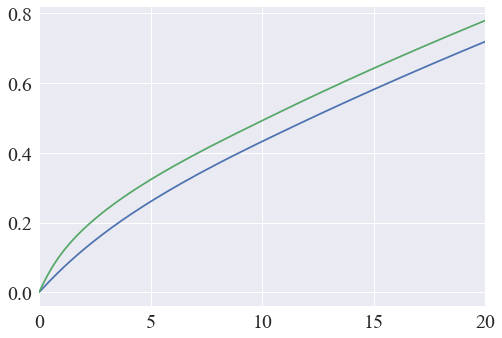

In [13]:
## solve the model 

start_time = time()
hark_mkv.solve()
end_time = time()
print(
    "Solving a Markov consumer with serially correlated unemployment took "
    + str(end_time - start_time)
    + " seconds."
)
print("Consumption functions for each discrete state:")
plot_funcs(hark_mkv.solution[0].cFunc, 0, 20)
if hark_mkv.vFuncBool:
    print("Value functions for each discrete state:")
    plot_funcs(hark_mkv.solution[0].vFunc, 5, 20)

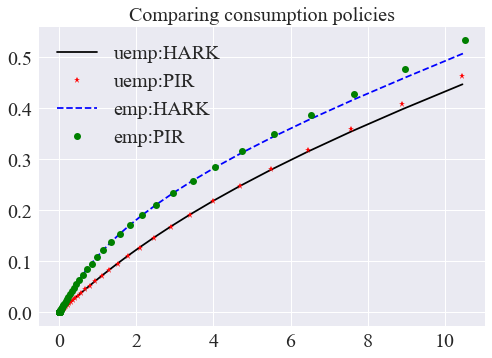

In [14]:
## compare the solutions 

## get the HARK c  
c_u_HARK = hark_mkv.solution[0].cFunc[0](m_plt_u)
c_e_HARK = hark_mkv.solution[0].cFunc[1](m_plt_e)

plt.title('Comparing consumption policies')
plt.plot(m_plt_u,c_u_HARK,'k-',label='uemp:HARK')
plt.plot(m_plt_u,c_plt_u,'r*',label='uemp:PIR')
plt.plot(m_plt_e,c_e_HARK,'b--',label='emp:HARK')
plt.plot(m_plt_e,c_plt_e,'go',label='emp:PIR')
plt.legend(loc=0)

### Comparing consumption policies under different risks 

[0.01]
[0.01]
Solving a Markov consumer with serially correlated unemployment took 0.17252779006958008 seconds.
[0.05]
[0.05]
Solving a Markov consumer with serially correlated unemployment took 0.16977620124816895 seconds.
[0.1]
[0.1]
Solving a Markov consumer with serially correlated unemployment took 0.16961002349853516 seconds.
[0.2]
[0.2]
Solving a Markov consumer with serially correlated unemployment took 0.17169404029846191 seconds.


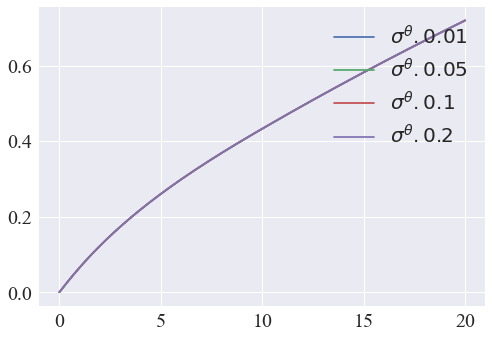

In [15]:
sigma_eps_ls = [0.01,0.05,0.1,0.2]
sigma_psi_ls = [0.01,0.05,0.1,0.2]

cFunc_list = []
for i,sigma_eps in enumerate(sigma_eps_ls):
    hark_mkv_para['TranShkStd'] = [sigma_eps]
    print(hark_mkv_para['TranShkStd'])
    hark_mkv_para['PermShkStd'] = [sigma_psi_ls[i]]
    print(hark_mkv_para['PermShkStd'])
    hark_mkv = MarkovConsumerType(**hark_mkv_para)
    hark_mkv.cycles = 0
    hark_mkv.vFuncBool = False  # for easy toggling here
    # Interest factor, permanent growth rates, and survival probabilities are constant arrays
    hark_mkv.assign_parameters(Rfree = np.array(2 * [hark_mkv.Rfree]))
    hark_mkv.PermGroFac = [
        np.array(2 * hark_mkv.PermGroFac)
    ]
    hark_mkv.LivPrb = [hark_mkv.LivPrb * np.ones(2)]
    # Replace the default (lognormal) income distribution with a custom one
    employed_income_dist = DiscreteDistribution(np.ones(1), [np.ones(1), np.ones(1)])  # Definitely get income
    unemployed_income_dist = DiscreteDistribution(np.ones(1), [np.ones(1), np.zeros(1)]) # Definitely don't
    hark_mkv.IncShkDstn = [
        [
            unemployed_income_dist,
            employed_income_dist
        ]
    ]
    ## solve the model 

    start_time = time()
    hark_mkv.solve()
    end_time = time()
    print(
        "Solving a Markov consumer with serially correlated unemployment took "
        + str(end_time - start_time)
        + " seconds."
    )
    
    #print("Consumption functions for each discrete state:")
    #plot_funcs(hark_mkv.solution[0].cFunc, 0, 20)
    cFunc_list.append(hark_mkv.solution[0].cFunc)
    
m_values = np.linspace(0.0,20.0,200)

for i,sigma_eps in enumerate(sigma_eps_ls):
    plt.plot(m_values,
             cFunc_list[i][0](m_values),
            label=r'$\sigma^\theta.{}$'.format(sigma_eps))
plt.legend(loc=1)

Solving a Markov consumer with serially correlated unemployment took 0.2740669250488281 seconds.
Solving a Markov consumer with serially correlated unemployment took 0.2750840187072754 seconds.
Solving a Markov consumer with serially correlated unemployment took 0.27885890007019043 seconds.
Solving a Markov consumer with serially correlated unemployment took 0.35478806495666504 seconds.


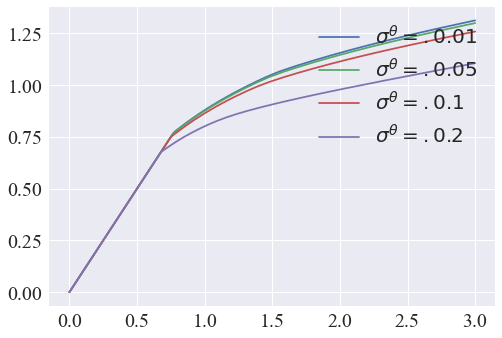

In [16]:
## for life cycle models 
import HARK.ConsumptionSaving.ConsIndShockModel as HARK_model         # The consumption-saving micro model

sigma_eps_ls = [0.01,0.05,0.1,0.2]
sigma_psi_ls = [0.01,0.05,0.1,0.2]

cFunc_list = []

for i,sigma_eps in enumerate(sigma_eps_ls):
    init_life_cycle_new = copy(init_lifecycle)
    lc_paras = copy(life_cycle_paras_y)
    #years_retire = lc_paras['L']- lc_paras['T']
    #init_life_cycle_new['T_cycle'] = lc_paras['L']-1   ## minus 1 because T_cycle is nb periods in a life cycle - 1 in HARK
    #init_life_cycle_new['T_retire'] = lc_paras['T']-1
    #init_life_cycle_new['LivPrb'] = [lc_paras['LivPrb']]*init_life_cycle_new['T_cycle']
    #init_life_cycle_new['PermGroFac'] = lc_paras['G']
    init_life_cycle_new['PermShkStd'] = [sigma_psi_ls[i]]*init_life_cycle_new['T_cycle']
    init_life_cycle_new['TranShkStd'] = [sigma_eps]*init_life_cycle_new['T_cycle']

    LifeCyclePop = HARK_model.IndShockConsumerType(**init_life_cycle_new)
    LifeCyclePop.cycles = 1
    LifeCyclePop.vFuncBool = False  # for easy toggling here
    
    ## solve the model 

    start_time = time()
    LifeCyclePop.solve()                            # Obtain consumption rules by age 
    LifeCyclePop.unpack('cFunc')                      # Expose the consumption rules
    end_time = time()
    print(
        "Solving a Markov consumer with serially correlated unemployment took "
        + str(end_time - start_time)
        + " seconds."
    )
    
    cFunc_list.append(LifeCyclePop.solution[50].cFunc)
    
m_values = np.linspace(0.0,3.0,200)

for i,sigma_eps in enumerate(sigma_eps_ls):
    plt.plot(m_values,
             cFunc_list[i](m_values),
            label=r'$\sigma^\theta=.{}$'.format(sigma_eps))
plt.legend(loc=1)

## Wealth distribution over life cycle 

In [17]:
## for life cycle 
init_life_cycle_new = copy(init_lifecycle)
lc_paras = copy(life_cycle_paras_y)


years_retire = lc_paras['L']- lc_paras['T']

init_life_cycle_new['T_cycle'] = lc_paras['L']-1   ## minus 1 because T_cycle is nb periods in a life cycle - 1 in HARK 
init_life_cycle_new['CRRA'] = lc_paras['ρ']
init_life_cycle_new['T_retire'] = lc_paras['T']-1
init_life_cycle_new['Rfree'] = lc_paras['R']
init_life_cycle_new['LivPrb'] = [lc_paras['LivPrb']]*init_life_cycle_new['T_cycle']
init_life_cycle_new['PermGroFac'] = lc_paras['G']
init_life_cycle_new['PermShkStd'] = [lc_paras['σ_ψ']]*init_life_cycle_new['T_retire']+[0.0]*years_retire
init_life_cycle_new['TranShkStd'] = [lc_paras['σ_θ']]*init_life_cycle_new['T_retire']+[0.0]*years_retire
init_life_cycle_new['DiscFac'] = lc_paras['β']
init_life_cycle_new['PermGroFacAgg'] = 1.0
init_life_cycle_new['aNrmInitMean']= np.log(lc_paras['init_b'])
init_life_cycle_new['aNrmInitStd']= 0.0
init_life_cycle_new['pLvlInitMean']= np.log(1.0)
init_life_cycle_new['pLvlInitStd']= lc_paras['σ_ψ_init']
init_life_cycle_new["UnempPrb"] = lc_paras['U']  # to make income distribution when employed
init_life_cycle_new['UnempPrbRet'] = 0.0
init_life_cycle_new['IncUnemp'] = 0.0
init_life_cycle_new['aXtraMax'] = 5.0

"""
LifeCycleType = MarkovConsumerType(**init_life_cycle_new)

LifeCycleType.cycles = 1 ## life cycle problem instead of infinite horizon
LifeCycleType.vFuncBool = False  ## no need to calculate the value for the purpose here 
"""

'\nLifeCycleType = MarkovConsumerType(**init_life_cycle_new)\n\nLifeCycleType.cycles = 1 ## life cycle problem instead of infinite horizon\nLifeCycleType.vFuncBool = False  ## no need to calculate the value for the purpose here \n'

In [18]:
print(init_life_cycle_new)

{'cycles': 1, 'CRRA': 2.0, 'Rfree': 1.01, 'DiscFac': 0.98, 'LivPrb': [0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375], 'PermGroFac': array([1.02955663, 1.02707112, 1.02472198, 1.02250445, 1.02041411,
       1.01844633, 1.01659667, 1.01486087, 1.01323462, 1.01171374,
       1.01029408, 1.00897133, 1.00774169, 1.0066011 , 1.00554514,
       1.00457048, 1.00367308, 1.00284863, 1.00209379, 1.00140452,
       1.00077689, 1.00020754, 0.99969214, 0.99922734, 0.99880946,
       0.99843448, 0.99809891, 0.99779904, 0.9975

In [19]:
import HARK.ConsumptionSaving.ConsIndShockModel as HARK_model         # The consumption-saving micro model
from HARK.utilities import plot_funcs_der, plot_funcs              # Some tools

In [20]:
LifeCyclePop = HARK_model.IndShockConsumerType(**init_life_cycle_new)
LifeCyclePop.cycles = 1
LifeCyclePop.vFuncBool = False  # for easy toggling here

In [21]:
LifeCyclePop.solve()                            # Obtain consumption rules by age 
LifeCyclePop.unpack('cFunc')                      # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop.track_vars = ['aNrm','pLvl','mNrm','cNrm']

LifeCyclePop.T_sim = lc_paras['L']              
LifeCyclePop.initialize_sim()                     # Construct the age-25 distribution of income and assets
LifeCyclePop.simulate()

{'aNrm': array([[0.7146994 , 0.68638267, 0.68638267, ..., 0.65511388, 0.68638267,
         0.74460751],
        [0.72544102, 0.89680281, 0.89003178, ..., 0.99863902, 0.68638267,
         0.84736661],
        [1.10236967, 0.99594381, 0.81903476, ..., 1.20737199, 1.0009218 ,
         1.31139517],
        ...,
        [2.58811802, 0.32929325, 0.19589796, ..., 0.54405051, 5.50668656,
         0.19525729],
        [3.21558547, 0.16066909, 0.09391784, ..., 0.268134  , 5.77744619,
         0.09359725],
        [4.31109272, 0.34365815, 0.27909599, ..., 0.44760948, 4.69849921,
         0.27878593]]),
 'pLvl': array([[3.57343842, 1.34186759, 2.76895234, ..., 0.58021672, 0.95794531,
         0.5497922 ],
        [4.62072349, 1.36623887, 3.17895644, ..., 0.66613053, 1.51024543,
         0.55977764],
        [4.16314487, 1.76238421, 4.10070504, ..., 0.53491678, 1.45503921,
         0.53801327],
        ...,
        [2.38473607, 1.2603351 , 6.15131941, ..., 0.27591316, 1.12931111,
         1.5928397

In [22]:
LifeCyclePop.history['aLvl'] = LifeCyclePop.history['aNrm']*LifeCyclePop.history['pLvl']
aGro41=LifeCyclePop.history['aLvl'][41]/LifeCyclePop.history['aLvl'][40]
aGro41NoU=aGro41[aGro41[:]>0.2] # Throw out extreme outliers
aGro41NoU = aGro41NoU[aGro41NoU[:]<2]

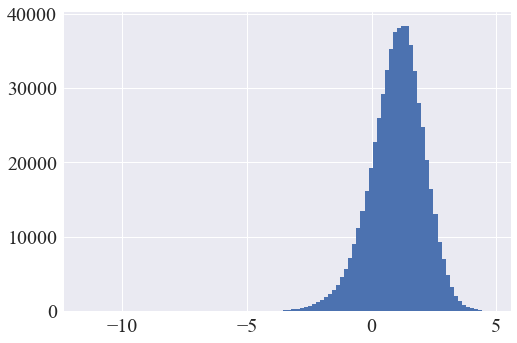

In [28]:
## wealth distribution  
wealth_dist=plt.hist(np.log(LifeCyclePop.history['aLvl'].flatten()+1e-5),bins=100)

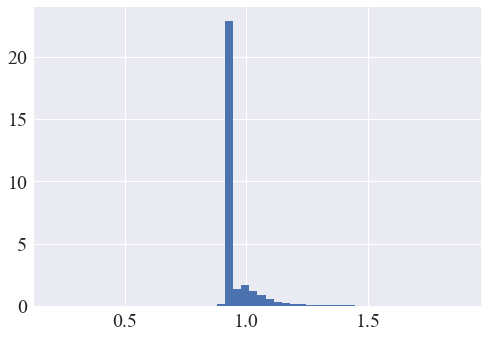

In [29]:
# Plot the distribution of growth rates of wealth between age 65 and 66 (=25 + 41)
n, bins, patches = plt.hist(aGro41NoU,50,density=True)

## Wealthy over life cycle  

In [30]:
A_life = LifeCyclePop.history['aLvl'].mean(axis=1)

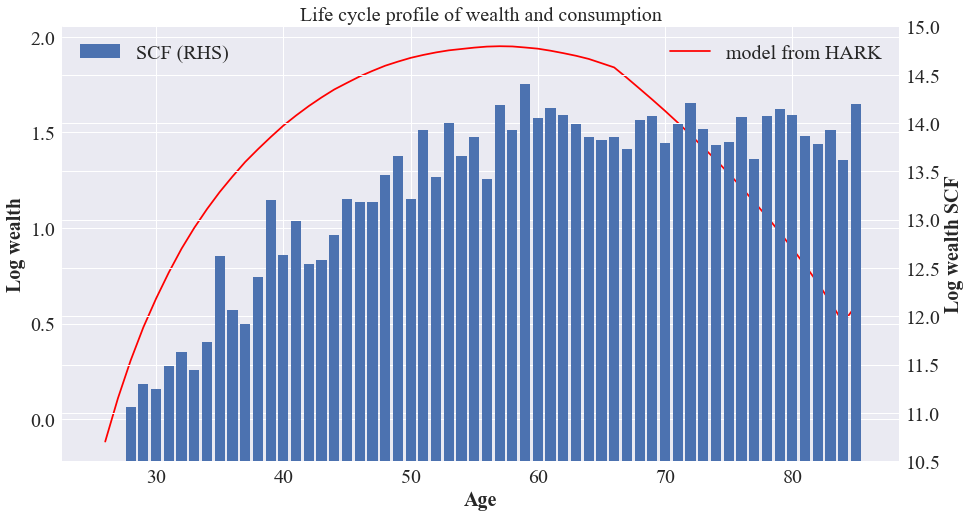

In [33]:
import pandas as pd
SCF_profile = pd.read_pickle('data/SCF_age_profile.pkl')

SCF_profile['mv_wealth'] = SCF_profile['av_wealth'].rolling(3).mean()
## plot life cycle profile

age_lc = SCF_profile.index

fig, ax = plt.subplots(figsize=(15,8))
plt.title('Life cycle profile of wealth and consumption')
ax.plot(age_lc[1:],
        np.log(A_life),
       'r-',
       label='model from HARK')

#ax.vlines(lc_mkv.T+25,
#          np.min(A_life),
#          np.max(A_life),
#          color='b',
#          label='retirement')

ax2 = ax.twinx()
ax2.set_ylim([10.5,15])
ax2.bar(age_lc[1:],
        np.log(SCF_profile['av_wealth'][1:]),
       #'k--',
       label='SCF (RHS)')

ax.set_xlabel('Age')
ax.set_ylabel('Log wealth')
ax2.set_ylabel('Log wealth SCF')
ax.legend(loc=1)
ax2.legend(loc=2)